# Implementation of Flood Fill Strategy for Instance Segmentation

The Flood Filling approach demonstrated by [Januszewski et al.](https://arxiv.org/abs/1611.00421) does not strictly depend on the underlying architecture of the FCCN used. Here we try to adapt the implented 3D Unet to be trained and used as a flood filling network.

Flood Filling networks actively construct a segmentation mask that is fed into the network together with the input image. This results in a quasi recurrent architecture that can incorporate previous predictions made for the border regions.

In inference mode the flood filling algorithm works as follows:
- Retrieve a Tile from the top of the working queue and ensure that is has not been visited before
- Evaluate the FCCN on a 3D Tile of training data and the segmentation canvas
- Write the FCCN ouput to the segmentation canvas
- Evaluate in which directions the object extends and add the respective tiles to a queue.

For training the segmentation canvas is initialy blank except for a single seed withing the object that is currently segmented. The training volume allows to jump at least to imediately neighbouring tiles and continue segmentation with the previous prediction before a new scene is loaded.

The following tasks need to be adresses in order to implement the flood filling approach:

Stage 1: Single object segmentation
The first intermediate goal is to segment single neuron data using the flood filling approach. This potentially reduces the number of tiles that need to be evaluated since the network explores the neuron processes. 

- Adapt the Unet to expect two channel input (image and segmentation mask)
- Write a class that 
  - tiles the image with overlapping tiles, 
  - maintains the segmentation mask, 
  - delivers appropriate slices of image and segmentation mask, 
  - maintains a tile coordinate queue that should be visited and 
  - prevents reevaluation of visited sites
- Write a custom training script that feeds a seeded segmentation mask and a small region of the image for training
- Write a custom evaluation script that executes segmentation of large volumes by running the segmentation loop over longer time

Stage 2: Multi Object Segmentation
In a next step image data and ground truth for multi neuron situations should be generated and used to train the FCCN so that it learns to ignore signals that are not adjacent to previously masked regions -> generalizes the network for instance segmentation.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time
import h5py
from tqdm import tqdm
from importlib import reload
import itertools

import tensorflow as tf
import ipywidgets
import utilities

In [2]:
# Import modules providing tools for image manipulation
import sys
sys.path.append('../tools')
import tilingStrategy, Dataset3D, visualization, metrics
sys.path.append('../3D Unet')
import model
import floodFill

In [3]:
# Fix for tensorflow-gpu issues that I found online... (don't ask me what it does)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1Physical GPUs,1Logical GPUs


## Data Input Pipeline for FFUnet Training

The training data is stored in a hdf5 file created with Dataset3D. 
Each entry contains a training scene that fits a grid of 3x3x3 evaluation positions for a given input and output shape together with the stepsize.
The scenes are loaded and preprocessed using tf data. During one epoch all scenes are used once.
From each scene, a FloodFiller instance is created that maintains a new processing queue and a segmentation canvas. The unet is trained on the scene until the queue of the FloodFiller is empty.

In [7]:
# Load images and masks from a previously created dataset
#base_dir = 'C:\\Users\\lillvisj\\linus\\'
base_dir = 'C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\'
dataset_path = base_dir+'ffn_dataset.h5'
dataset = Dataset3D.Dataset(dataset_path) # The Dataset3D class handles all file level i/o operations

print('Dataset {} contains {} records'.format(dataset, len(dataset)))

print('Dataset metadata entries:')
print(dataset.getAttributes().keys())
for key in dataset.getAttributes().keys():
    print(key + ' : ' + str(dataset.getAttributes().get(key)))

#Maybe look at en entry
print(dataset.keys())
im, msk, meta = dataset.get('a_10')

Opened dataset with 35 preexisting items. Overwriting items with the same name.
Dataset <Dataset3D.Dataset object at 0x0000022BA1FC3548> contains 35 records
Dataset metadata entries:
<KeysViewHDF5 ['comment', 'input_shape', 'stepsize']>
comment : This dataset is intended for flood filling network training. Each training example allows for a grid of 3x3x3 evaluations. Each example is guaranteed to contain the object at the central pixel of the example
input_shape : [220 220 220]
stepsize : [8 8 8]
<KeysViewHDF5 ['a_1', 'a_10', 'a_12', 'a_13', 'a_14', 'a_15', 'a_16', 'a_17', 'a_18', 'a_2', 'a_21', 'a_22', 'a_24', 'a_25', 'a_26', 'a_27', 'a_28', 'a_30', 'a_31', 'a_33', 'a_35', 'a_36', 'a_37', 'a_40', 'a_41', 'a_42', 'a_44', 'a_45', 'a_46', 'a_47', 'a_48', 'a_49', 'a_6', 'a_7', 'a_8']>


In [8]:
# DEFINE UNET GEOMETRY
input_shape = (220,220,220)
delta = (8,8,8)
# with two downsampling blocks this implies
output_shape = (132,132,132)

In [9]:
# get a list of all records in the database
entries = list(dataset.keys())

# Make a train test split and retrieve a callable -> that produces a generator -> that yields the recods specified by the key list in random order
training = dataset.getGenerator(entries[:30])
test = dataset.getGenerator(entries[:30])

# gen = training() # calling the callable training produces a generator
# next(gen) -> (image, mask) yields the records identified by the key list

In [10]:
# Instantiate tf Datasets from the generator producing callables, specify the datatype and shape of the generator output
trainingset_raw = tf.data.Dataset.from_generator(training, 
    output_types=(tf.float32, tf.int32),
    output_shapes=(tf.TensorShape([236,236,236]),tf.TensorShape([236,236,236])))

testset_raw = tf.data.Dataset.from_generator(test, 
    output_types=(tf.float32, tf.int32),
    output_shapes=(tf.TensorShape([236,236,236]),tf.TensorShape([236,236,236])))

# each scene is preprocessed by passing it through this function
def preprocessScene(x,y):
    # clip, and z normalize image
    x = tf.clip_by_value(x, 0, 1400)
    x = tf.subtract(x, 140)
    x = tf.divide(x, 40)
    # binarize mask
    y = tf.clip_by_value(y,0,1)
   
    return x, y

# Each Tile that is provided by a Flood Filler is passed
def preprocessTile(image, segmentation, mask):
    x = tf.stack([image,segmentation], axis=-1) # stack image and segmentation state at the channel axis
    x = tf.expand_dims(x, axis= 0) # add batch dimension
    y = tf.one_hot(mask, depth=2, dtype=tf.float32) # one hot encode binary mask to float tensor
    y = tf.clip_by_value(y, 0.05, 0.95) # use soft labels to prevent nummerical issues during training
    y = tf.expand_dims(y, axis=0)
    return x, y


# Crop Mask
def crop_mask(x, y, mask_size=(132,132,132)):
    # apply crop after batch dimension is added x and y have (b,x,y,z,c) format while mask size has (x,y,z) format => add offset of 1
    crop = [(y.shape[d+1]-mask_size[d])//2 for d in range(3)]
    #keras implicitly assumes channels last format
    y = tf.keras.layers.Cropping3D(cropping=crop)(y)
    return x, y

# chain dataset transformations to construct the input pipeline for training
# 1. preprocess the raw data by clipping and normalizing the image. The mask is binarized and one hot encoded. A new axis is added to the image tensors -> (x,y,z,c) format
# 2. Apply data augumentation if desired. Random affine transformations and elastic transformations can be applied to both tensors. This mapping operation can be parallelized to increase throughput as this is the most time consuming step in preprocessing. The number of parallel calls is automatically tuned for performance. 
# 3. Some training examples are prefetched which decouples preprocessing from model execution. The number of prefetched samples is tuned automatically for performance. 

trainingset = trainingset_raw.map(preprocessScene).map(utilities.tf_affine).prefetch(1) # x-> (x,y,z) y-> (x,y,z)
testset = testset_raw.map(preprocessScene).map(utilities.tf_affine).prefetch(1)

In [11]:
# Convert the image mask pairs to Flood Filler instances
def parseScene(x: tf.Tensor, y: tf.Tensor) -> floodFill.FloodFiller:
    ff = floodFill.constructExample(x, y, output_shape, input_shape, delta)
    return ff

In [12]:
if False:
    # Try out scene and example construction
    train_it = iter(trainingset)
    scene_image, scene_mask = next(train_it) # both (x,y,z), (236px)^3
    ff = parseScene(scene_image, scene_mask)
    ff.shape # 3x3x3 tiling
    # retrieve the input image, segmentation canvas and mask of the tile that should be evaluated
    index, im, seg, msk = ff.getNext() # (220px)^3, (220px)^3, (132px)^3, all (x,y,z)
    # preprocess the tile to get unet input
    x, y = preprocessTile(im,seg,msk) # x: (b,x,y,z,c) (1,220,220,220,2) (c0:preprocessed image, c1: segmentation mask) y: (b,x,y,z,c) (1,132,132,132,2) (soft one hot mask)

## Adapting the Unet architecture to the Flood Filling algorithm

In order for the Unet to be compatible to the Flood Filling algorithm, a few adaptations need to be made:
- The Unet should directly output a probability map for an object to belong to the neuron -> add a softmax layer so that each channel is a pseudoprobability map for it's respective class
- To prevent nummerical issues, 0.05 and 0.95 are used as target probabilities for the background or foreground respectively. Binary masks should be preprocessed accordingly

In [13]:
reload(model)

<module 'model' from '../3D Unet\\model.py'>

In [14]:
unet = model.build_unet(input_shape=(220,220,220,2), # Use two channels to feed image and segmentation canvas
                        n_blocks=2,
                        initial_filters=4,
                        useSoftmax = True # Add a softmax layer to get pseudoprobability maps in output channels
                        )


Model predicts softmax pseudoprobabilities


In [15]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to
input_1 (InputLayer)            [(None, 220, 220, 22 0
__________________________________________________________________________________________________
input_block (InputBlock)        ((None, 108, 108, 10 1092        input_1[0][0]
__________________________________________________________________________________________________
downsample_block (DownsampleBlo ((None, 52, 52, 52,  5208        input_block[0][0]
__________________________________________________________________________________________________
downsample_block_1 (DownsampleB ((None, 24, 24, 24,  20784       downsample_block[0][0]
__________________________________________________________________________________________________
bottleneck_block (BottleneckBlo (None, 40, 40, 40, 6 115872      downsample_block_1[0][0]
_________________

## Building a custom training loop for flood filling Unet

The code provided in the [keras tutorial](https://keras.io/guides/writing_a_training_loop_from_scratch/) on custom training loops is used as backbone to train the FFUnet. 



In [16]:
# DEFINE LOSS, METRICS and OPTIMIZER

# Generate a callable loss function that expects y_pred to be probabilities
loss_fn = model.weighted_categorical_crossentropy(class_weights=[1,40], fromLogits=False)

# Set up metrics that should be tracked during training
training_acc = tf.keras.metrics.CategoricalAccuracy()
training_iou = metrics.MeanIoU(num_classes=2)
validation_acc = tf.keras.metrics.CategoricalAccuracy()
validation_iou = metrics.MeanIoU(num_classes=2)

# Define an optimizer to update the model weights given the respective gradients of the loss function
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [17]:
# DEFINE TRAINING STEP
# Decorate as tf function to allow static computational graph compilation
#@tf.function
# Execute this step on each training instance (data, labels)
def train_step(x, y):
    # Open a gradient tape to track derivates with respect to model weights
    with tf.GradientTape() as tape:
        # predict probability maps in training mode
        y_pred = unet(x, training=True)
        # Compute the loss 
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, unet.trainable_weights)
    optimizer.apply_gradients(zip(grads, unet.trainable_weights))
    # Accumulate metrics
    training_acc.update_state(y, y_pred)
    training_iou.update_state(y, y_pred)

    return loss_value, y_pred

In [18]:
# DEFINE TEST STEP
@tf.function
def test_step(x, y):
    y_pred = unet(x, training=False)
    validation_acc.update_state(y,y_pred)
    validation_iou.update_state(y,y_pred)
    return y_pred

In [19]:
# Define the number of epochs
epochs = 1

# Set up saving intervalls
save_step = 2 
directory = 'train0826/'
try:
    os.makedirs(directory)
except:
    pass

# track loss and metrics for each epoch
history = {'trainig_loss' : [], 'training_acc': [], 'training_iou' : [],
             'validation_acc': [], 'validation_iou' : []}

# Save the model architecture
model.save(directory+'model.h5')

for epoch in range(epochs):
    # Announce epoch
    print('-- EPOCH {} --'.format(epoch))
    start_time = time.time()

    # NEW EPOCH 
    # Get e new iterator over the training set
    train_it = iter(trainingset)
    tiles_seen_in_epoch = 0 # count the tiles seen in this epoch
    epoch_training_loss = []

    # Iterate over the scenes of the dataset.
    for step, (image, mask) in enumerate(train_it):

        # Create an initialized Flood Filler instance from the scene
        # If data preprocessing leads to a situation without any object pixels in the central tile,
        # the returned FloodFiller instance has en empty queue so that trainig skips to the next scene
        ff = parseScene(image, mask)
        tiles_seen_in_scene = 0

        # Evaluate the model on the training scene, until the queue of the flood filler is empty
        while ff.hasNext():
            # retrieve the input image, segmentation canvas and mask of the tile that should be evaluated
            index, im, seg, msk = ff.getNext()
            # preprocess the tile to get unet input
            x, y = preprocessTile(im,seg,msk)
            # perform a training step
            loss_value, seg_pred = train_step(x, y)
            # write unet ouput to segmentation canvas and update queue
            ff.writeSlice(index,seg_pred[0,:,:,:,1])
            ff.queueHeuristic(index,seg_pred[0,:,:,:,1], threshold=0.9)
            # Keep track of training progress
            tiles_seen_in_epoch+=1
            tiles_seen_in_scene+=1
            # acumulate epoch loss
            epoch_training_loss.append(loss_value.numpy()[0])
            #print(loss_value.numpy())

        # Give feedback on training scene
        print('SCENE {} trained on {} tiles'.format(step,tiles_seen_in_scene))

    # Save and display metrics at the end of each epoch.
    history['training_loss'].append(np.mean(epoch_training_loss))
    history['training_acc'].append(training_acc.result())
    history['training_iou'].append(training_iou.result())
    print('Training loss over epoch: {}'.format(history['training_loss'][-1]))
    print("Training acc over epoch: {}".format(history['training_acc'][-1]))
    print("Training iou over epoch: {}".format(history['training_iou'][-1]))

    # Reset training metrics at the end of each epoch
    training_acc.reset_states()
    training_iou.reset_states()

    # Save model weights in regular intervalls
    if  epoch % save_step == 0 or epoch == epochs-1:
        savepath = directory + 'weights_{}'.format(epoch)
        model.save_weights(savepath)

    # Run a validation loop at the end of each epoch.
    # get a new iterator over the validation set
    val_it = iter(testset)
    for image, mask in val_it:

        # Create an initialized Flood Filler instance from the scene
        ff = parseScene(image, mask)
        # Run the unet on the scene and accumulate validation metrics
        while ff.hasNext():
            # retrieve the input image, segmentation canvas and mask of the tile that should be evaluated
            index, im, seg, msk = ff.getNext()
            # preprocess the tile to get unet input
            x, y = preprocessTile(im,seg,msk)
            # perform a test step
            seg_pred = test_step(x, y)
            # write unet ouput to segmentation canvas
            ff.writeSlice(index,seg_pred[0,:,:,:,1])
            ff.queueHeuristic(index,seg_pred[0,:,:,:,1], threshold=0.9)


    history['validation_acc'].append(validation_acc.result())
    history['validation_iou'].append(validation_iou.result())
    validation_acc.reset_states()
    validation_iou.reset_states()
    print('Validation accurarcy : {}'.format(history['validation_acc'][-1]))
    print('Validation IoU : {}'.format(history['validation_iou'][-1]))
    print("Time taken: %.2fs" % (time.time() - start_time))

-- EPOCH 0 --
[4.1967683]
[3.0796416]
[3.0407562]
[3.0545304]
[2.9711301]
[2.9090946]
[2.8988082]
[2.8897629]
[2.928101]
[2.9844205]
[2.8576224]
[2.8312972]
[2.849047]
[2.8795428]
[2.808331]
[2.7999725]
[2.8174362]
[2.8014264]
[2.837005]
[2.8704891]
[2.8905761]
[2.8065615]
[2.750053]
[2.774097]
[2.7638521]
[2.7697828]
[2.7135582]
SCENE 0 trained on 27 tiles
[2.6066844]
[2.562405]
[2.558479]
[2.4975367]
[2.5004835]
[2.4926424]
[2.4677036]
[2.4396775]
[2.4217715]
[2.3953013]
[2.4514399]
[2.46111]
[2.442702]
[2.4166865]
[2.4424212]
[2.4437902]
[2.427112]
[2.401898]
[2.3904512]
[2.3309934]
[2.2896626]
[2.3454852]
[2.3346782]
[2.3314695]
[2.2912385]
[2.2498925]
[2.3060844]
SCENE 1 trained on 27 tiles
[2.6104488]
[2.5174916]
[2.533309]
[2.4549875]
[2.4920151]
[2.5252967]
[2.4985788]
[2.4566646]
[2.3985736]
[2.337436]
[2.4511933]
[2.4568102]
[2.407813]
[2.3549724]
[2.4830997]
[2.5155666]
[2.4712253]
[2.4492598]
[2.4071805]
[2.2670534]
[2.2511134]
[2.330962]
[2.3672178]
[2.3453856]
[2.2587547]

## Inference mode

Construct the segmentation output for a single image, mask pair in the validation set.

In [24]:
reload(floodFill)

<module 'floodFill' from 'c:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\FloodFillingUnet\\floodFill.py'>

In [25]:
test_it = iter(testset)

In [49]:
image, mask = next(test_it)
ff = parseScene(image, mask)
tiles = 0

while ff.hasNext():
    tile_index, im, seg, msk = ff.getNext()
    x, y = preprocessTile(im,seg,msk)
    seg_pred = unet.predict(x)[0,:,:,:,1]
    ff.writeSlice(tile_index,seg_pred)
    ff.queueHeuristic(tile_index,seg_pred, threshold=0.9)
    tiles+=1

print('Processed {} tiles'.format(tiles))

Processed 10 tiles


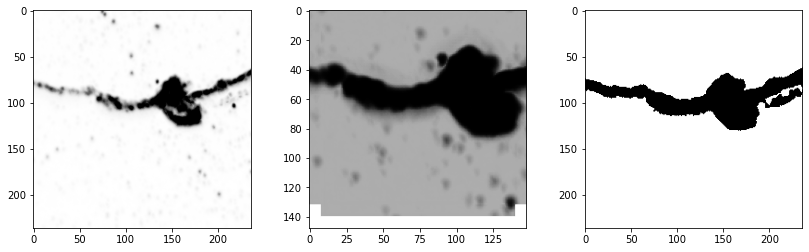

In [50]:
segmentation = ff.segmentation.image[44:192,44:192,44:192]
visualization.showProjections([image,segmentation,mask], mode='max', cmap='Greys')